# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.under_sampling import NearMiss
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

C:\Users\nazli\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load Data

In [2]:
Attack_data=pd.read_csv('s3://attackproof/Attack_data.csv')

C:\Users\nazli\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(Attack_data.shape)

(2300825, 79)


In [3]:
print(Attack_data[' Label'].value_counts(normalize=True) * 100)

Normal           75.763215
DoS              16.546195
Port_Scan         6.907522
Brute_Force       0.601306
Web_attack        0.094749
Botnet            0.085448
infilteration     0.001565
Name:  Label, dtype: float64


In [4]:
print(Attack_data[' Label'].value_counts())

Normal           1743179
DoS               380699
Port_Scan         158930
Brute_Force        13835
Web_attack          2180
Botnet              1966
infilteration         36
Name:  Label, dtype: int64


# Drop Duplicate Values

In [5]:
Attack_data=Attack_data.drop_duplicates()

# Drop Null and INF

In [6]:
NaN_values=Attack_data.isnull().sum()
null=Attack_data.columns[Attack_data.isnull().any()]
print(NaN_values)

 Destination Port                 0
 Flow Duration                    0
 Total Fwd Packets                0
 Total Backward Packets           0
Total Length of Fwd Packets       0
 Total Length of Bwd Packets      0
 Fwd Packet Length Max            0
 Fwd Packet Length Min            0
 Fwd Packet Length Mean           0
 Fwd Packet Length Std            0
Bwd Packet Length Max             0
 Bwd Packet Length Min            0
 Bwd Packet Length Mean           0
 Bwd Packet Length Std            0
Flow Bytes/s                    302
 Flow Packets/s                   0
 Flow IAT Mean                    0
 Flow IAT Std                     0
 Flow IAT Max                     0
 Flow IAT Min                     0
Fwd IAT Total                     0
 Fwd IAT Mean                     0
 Fwd IAT Std                      0
 Fwd IAT Max                      0
 Fwd IAT Min                      0
Bwd IAT Total                     0
 Bwd IAT Mean                     0
 Bwd IAT Std                

In [7]:
inf_flowbyte=Attack_data.drop(Attack_data.index[Attack_data['Flow Bytes/s'] == 'Infinity'])
inf_flowpacket=Attack_data.drop(Attack_data.index[Attack_data[' Flow Packets/s'] == 'Infinity'])
inf_flowbyte['Flow Bytes/s']=inf_flowbyte['Flow Bytes/s'].astype('float64')
inf_flowpacket[' Flow Packets/s']=inf_flowpacket[' Flow Packets/s'].astype('float64')

In [8]:
Max_flowbyte=np.max(inf_flowbyte['Flow Bytes/s'])
Mean_flowbyte=np.mean(inf_flowbyte['Flow Bytes/s'])
Max_flowpacket=np.max(inf_flowpacket[' Flow Packets/s'])

In [9]:
Attack_data['Flow Bytes/s'].replace('Infinity',Max_flowbyte,inplace=True)
Attack_data['Flow Bytes/s'].fillna(Mean_flowbyte,inplace=True)
Attack_data[' Flow Packets/s'].replace('Infinity',Max_flowpacket,inplace=True)

In [10]:
print(Attack_data.dtypes.unique())

[dtype('int64') dtype('float64') dtype('O')]


# Label Encoder

In [11]:
Attack_data['Int_Label'] = Attack_data[' Label'].copy()

In [12]:
le = preprocessing.LabelEncoder()
Attack_data['Int_Label'] = le.fit_transform(Attack_data.Int_Label.values)

In [13]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Botnet': 0, 'Brute_Force': 1, 'DoS': 2, 'Normal': 3, 'Port_Scan': 4, 'Web_attack': 5, 'infilteration': 6}


# Scale

In [14]:
X =Attack_data.drop([' Label','Int_Label'],axis=1) 
scaler=MinMaxScaler()
Attack_data_Scale=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
print(Attack_data_Scale.describe())

        Destination Port   Flow Duration   Total Fwd Packets  \
count       2.033155e+06    2.033155e+06        2.033155e+06   
mean        1.227865e-01    1.489166e-01        4.367764e-05   
std         2.772809e-01    3.025185e-01        3.645944e-03   
min         0.000000e+00    0.000000e+00        0.000000e+00   
25%         8.087528e-04    1.850000e-06        4.808548e-06   
50%         1.220759e-03    4.503500e-04        4.808548e-06   
75%         6.759953e-03    4.754922e-02        2.404274e-05   
max         1.000000e+00    1.000000e+00        1.000000e+00   

        Total Backward Packets  Total Length of Fwd Packets  \
count             2.033155e+06                 2.033155e+06   
mean              3.994260e-05                 4.816364e-05   
std               3.559411e-03                 8.800916e-04   
min               0.000000e+00                 0.000000e+00   
25%               3.513679e-06                 9.302326e-07   
50%               7.027358e-06               

C:\Users\nazli\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


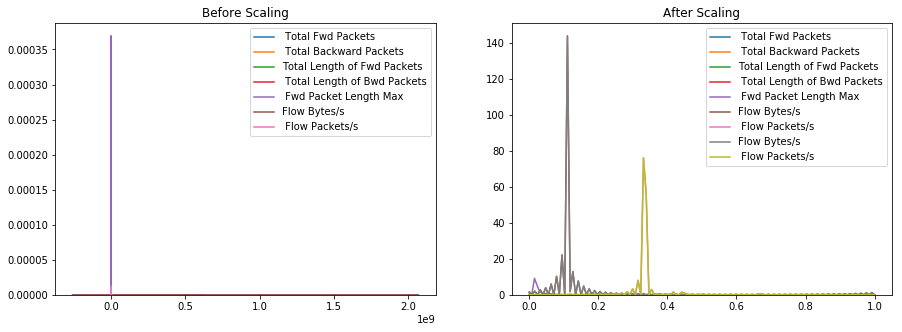

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(Attack_data[' Total Fwd Packets'], ax=ax1)
sns.kdeplot(Attack_data[' Total Backward Packets'], ax=ax1)
sns.kdeplot(Attack_data['Total Length of Fwd Packets'], ax=ax1)
sns.kdeplot(Attack_data[' Total Length of Bwd Packets'], ax=ax1)
sns.kdeplot(Attack_data[' Fwd Packet Length Max'], ax=ax1)
sns.kdeplot(Attack_data['Flow Bytes/s'], ax=ax1)
sns.kdeplot(Attack_data[' Flow Packets/s'], ax=ax1)

ax2.set_title('After Scaling')
sns.kdeplot(Attack_data_Scale[' Total Fwd Packets'], ax=ax2)
sns.kdeplot(Attack_data_Scale[' Total Backward Packets'], ax=ax2)
sns.kdeplot(Attack_data_Scale['Total Length of Fwd Packets'], ax=ax2)
sns.kdeplot(Attack_data_Scale[' Total Length of Bwd Packets'], ax=ax2)
sns.kdeplot(Attack_data_Scale[' Fwd Packet Length Max'], ax=ax2)
sns.kdeplot(Attack_data_Scale['Flow Bytes/s'], ax=ax2)
sns.kdeplot(Attack_data_Scale[' Flow Packets/s'], ax=ax2)
sns.kdeplot(Attack_data_Scale['Flow Bytes/s'], ax=ax2)
sns.kdeplot(Attack_data_Scale[' Flow Packets/s'], ax=ax2)

# Imbalance

In [16]:
Attack_data_Scale_TDF=pd.concat([Attack_data_Scale, Attack_data[[' Label']]], axis = 1)
Attack_data_Scale_TDF2=pd.concat([Attack_data_Scale_TDF, Attack_data[['Int_Label']]], axis = 1)

In [17]:
Count_Normal_transacation = len(Attack_data_Scale_TDF2[Attack_data_Scale_TDF2["Int_Label"]==3]) # normal transaction are repersented by 0
Count_Fraud_transacation = len(Attack_data_Scale_TDF2[Attack_data_Scale_TDF2["Int_Label"]!=3]) # fraud by 1
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("percentage of normal transacation is",Percentage_of_Normal_transacation*100)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("percentage of fraud transacation",Percentage_of_Fraud_transacation*100)

percentage of normal transacation is 70.96099517500292
percentage of fraud transacation 29.03900482499707


In [16]:
fd=X_train
rf_F = RandomForestClassifier(n_estimators=1000,
                   max_depth= 80,
                   min_samples_split= 10,
                   min_samples_leaf= 1,
                   bootstrap= False)
rf_F.fit(fd, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
from sklearn.externals import joblib
filename = 'Attack_model.sav'
joblib.dump(rf_F, filename)

['Attack_model.sav']

In [19]:
# Predicting the Test set results
y_pred = rf_F.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
reversefactor = dict(zip(range(7),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted    0       1     2    3      4      5  6
Actual                                            
0          636      20     0    0      1      5  0
1            1  480339     0   67     80    304  0
2            1       1  2861    0      0      0  0
3            0     135     0  457      0      0  0
4            3     164     0    0  96764      0  0
5            3     264     0    0      7  27826  0
6            0       3     0    0      0      0  5
